<a href="https://colab.research.google.com/github/Riyasingh22600/ml-fundamentals-assignment/blob/main/ch1-2_notes/ch3_numpy_pandas/ch4_eda/ch5_feature_engineering/ch6_models/ch7_metrics/ch8_advanced_topics/ch8_advanced_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: Advanced Topics & Best Practices

---

COMPREHENSIVE CROSS-VALIDATION DEMONSTRATION

1. CREATING DEMONSTRATION DATASETS
Classification dataset: 1000 samples, 10 features
Class distribution: [336 332 332]
Regression dataset: 1000 samples, 10 features
Target range: [-449.01, 411.14]
Time series dataset: 195 samples, 5 lag features

2. K-FOLD CROSS-VALIDATION
K-Fold Cross-Validation Results (Classification):

K = 3 folds:
--------------------
Logistic Regression : 0.6930 (±0.0139) [0.6817, 0.7126]
Random Forest       : 0.8360 (±0.0052) [0.8288, 0.8408]
Decision Tree       : 0.7540 (±0.0106) [0.7447, 0.7688]

K = 5 folds:
--------------------
Logistic Regression : 0.6870 (±0.0317) [0.6300, 0.7250]
Random Forest       : 0.8470 (±0.0189) [0.8100, 0.8600]
Decision Tree       : 0.7590 (±0.0128) [0.7400, 0.7800]

K = 10 folds:
--------------------
Logistic Regression : 0.6920 (±0.0349) [0.6400, 0.7600]
Random Forest       : 0.8410 (±0.0370) [0.7700, 0.9000]
Decision Tree       : 0.7580 (±0.0417) [0.6900, 0.8300]

3. STRATIFIED K-FOL

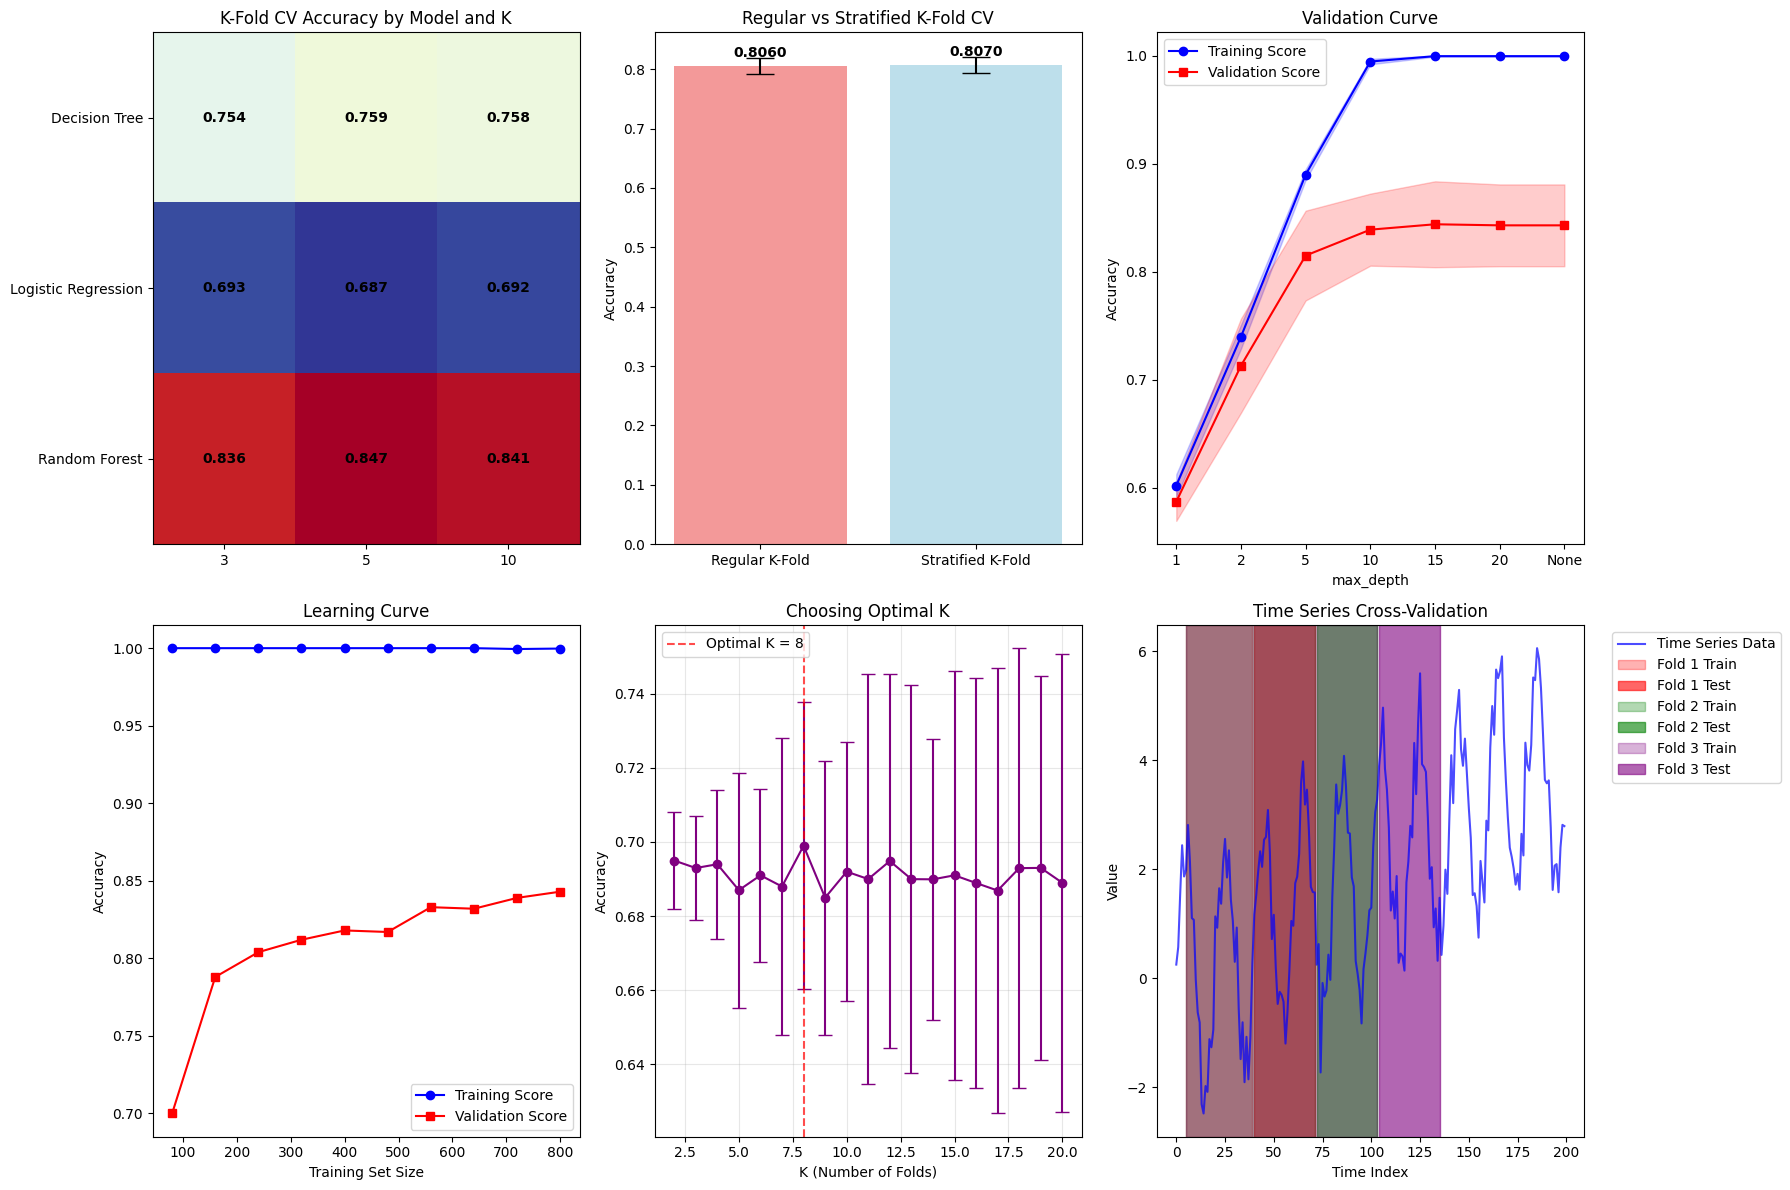


CROSS-VALIDATION SUMMARY AND RECOMMENDATIONS
General Purpose     : Use 5-fold or 10-fold cross-validation
Small Datasets      : Consider LOOCV, but beware of computational cost
Imbalanced Data     : Always use Stratified K-Fold
Time Series         : Use TimeSeriesSplit to avoid data leakage
Large Datasets      : 5-fold CV balances accuracy and speed
Model Selection     : Use validation curves to tune hyperparameters
Performance         : Use learning curves to check overfitting/underfitting
Computational Budget: Lower K for speed, higher K for stability

Key Insights:
- Optimal K for this dataset: 8
- Stratified CV stabilizes results on imbalanced data
- LOOCV gives detailed results but is expensive
- Time Series CV prevents leakage in temporal data
- Multiple metrics provide better evaluation


In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    KFold, StratifiedKFold, LeaveOneOut, TimeSeriesSplit,
    cross_val_score, cross_validate, validation_curve, learning_curve
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import make_classification, make_regression

import time
import warnings
warnings.filterwarnings('ignore')

# --- Safe Wrapper for make_classification ---
def safe_make_classification(n_samples=1000, n_features=10, n_classes=3,
                             n_clusters_per_class=2, weights=None, random_state=42):
    min_informative = int(np.ceil(np.log2(n_classes * n_clusters_per_class)))
    n_informative = max(min_informative, min(5, n_features-1))  # safe bound
    n_redundant = max(0, n_features - n_informative)
    return make_classification(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, n_redundant=n_redundant,
        n_classes=n_classes, weights=weights, random_state=random_state
    )

print("="*70)
print("COMPREHENSIVE CROSS-VALIDATION DEMONSTRATION")
print("="*70)

# =========================================================
# SECTION 1: CREATE DATASETS
# =========================================================
print("\n" + "="*50)
print("1. CREATING DEMONSTRATION DATASETS")
print("="*50)

# Balanced classification dataset
X_class, y_class = safe_make_classification()
print(f"Classification dataset: {X_class.shape[0]} samples, {X_class.shape[1]} features")
print(f"Class distribution: {np.bincount(y_class)}")

# Regression dataset
X_reg, y_reg = make_regression(
    n_samples=1000, n_features=10, noise=0.1, random_state=42
)
print(f"Regression dataset: {X_reg.shape[0]} samples, {X_reg.shape[1]} features")
print(f"Target range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

# Time series dataset
np.random.seed(42)
n_time_samples = 200
time_index = np.arange(n_time_samples)
trend = 0.02 * time_index
seasonal = 2 * np.sin(2 * np.pi * time_index / 20)
noise = np.random.normal(0, 0.5, n_time_samples)
y_time_series = trend + seasonal + noise

def create_time_series_features(y, n_lags=5):
    X = np.zeros((len(y) - n_lags, n_lags))
    y_shifted = np.zeros(len(y) - n_lags)
    for i in range(n_lags, len(y)):
        X[i - n_lags] = y[i - n_lags:i]
        y_shifted[i - n_lags] = y[i]
    return X, y_shifted

X_time, y_time = create_time_series_features(y_time_series, n_lags=5)
print(f"Time series dataset: {X_time.shape[0]} samples, {X_time.shape[1]} lag features")

# =========================================================
# SECTION 2: K-FOLD CROSS-VALIDATION
# =========================================================
print("\n" + "="*50)
print("2. K-FOLD CROSS-VALIDATION")
print("="*50)

k_values = [3, 5, 10]
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

print("K-Fold Cross-Validation Results (Classification):")
print("="*60)

k_fold_results = []
for k in k_values:
    print(f"\nK = {k} folds:")
    print("-" * 20)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for model_name, model in models.items():
        scores = cross_val_score(model, X_class, y_class, cv=kf, scoring='accuracy')
        result = {
            'K': k,
            'Model': model_name,
            'Mean_Accuracy': scores.mean(),
            'Std_Accuracy': scores.std(),
            'Min_Accuracy': scores.min(),
            'Max_Accuracy': scores.max()
        }
        k_fold_results.append(result)
        print(f"{model_name:20}: {scores.mean():.4f} (±{scores.std():.4f}) "
              f"[{scores.min():.4f}, {scores.max():.4f}]")

k_fold_df = pd.DataFrame(k_fold_results)

# =========================================================
# SECTION 3: STRATIFIED K-FOLD
# =========================================================
print("\n" + "="*50)
print("3. STRATIFIED K-FOLD CROSS-VALIDATION")
print("="*50)

X_imbal, y_imbal = safe_make_classification(weights=[0.7, 0.2, 0.1])
print(f"Imbalanced dataset class distribution: {np.bincount(y_imbal)}")

kf_regular = KFold(n_splits=5, shuffle=True, random_state=42)
kf_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(random_state=42, max_iter=1000)

scores_regular = cross_val_score(model, X_imbal, y_imbal, cv=kf_regular, scoring='accuracy')
scores_stratified = cross_val_score(model, X_imbal, y_imbal, cv=kf_stratified, scoring='accuracy')

print(f"\nRegular K-Fold: {scores_regular.mean():.4f} (±{scores_regular.std():.4f})")
print(f"Stratified K-Fold: {scores_stratified.mean():.4f} (±{scores_stratified.std():.4f})")

# =========================================================
# SECTION 4: LEAVE-ONE-OUT
# =========================================================
print("\n" + "="*50)
print("4. LEAVE-ONE-OUT CROSS-VALIDATION")
print("="*50)

X_small, y_small = safe_make_classification(n_samples=100)
loo = LeaveOneOut()
loocv_model = LogisticRegression(random_state=42, max_iter=1000)
loocv_scores = cross_val_score(loocv_model, X_small, y_small, cv=loo, scoring='accuracy')

print(f"LOOCV Mean Accuracy: {loocv_scores.mean():.4f} (±{loocv_scores.std():.4f})")
print(f"Number of folds: {len(loocv_scores)}")

# =========================================================
# SECTION 5: TIME SERIES CROSS-VALIDATION
# =========================================================
print("\n" + "="*50)
print("5. TIME SERIES CROSS-VALIDATION")
print("="*50)

tscv = TimeSeriesSplit(n_splits=5)
ts_model = LinearRegression()

print("Time Series Split Pattern:")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_time), 1):
    print(f"Fold {fold}: Train={len(train_idx)}, Test={len(test_idx)}")

ts_scores = cross_val_score(ts_model, X_time, y_time, cv=tscv, scoring='r2')
print(f"\nTime Series CV R2 scores: {ts_scores}")
print(f"Mean R2: {ts_scores.mean():.4f} (±{ts_scores.std():.4f})")

# =========================================================
# SECTION 6: ADVANCED CROSS-VALIDATION
# =========================================================
print("\n" + "="*50)
print("6. ADVANCED CROSS-VALIDATION TECHNIQUES")
print("="*50)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
multi_scores = cross_validate(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_class, y_class, cv=5, scoring=scoring, return_train_score=True
)

print("\nMulti-metric results:")
for metric in scoring:
    test_score = multi_scores[f'test_{metric}']
    train_score = multi_scores[f'train_{metric}']
    print(f"{metric:15}: Test {test_score.mean():.4f} (±{test_score.std():.4f}), "
          f"Train {train_score.mean():.4f} (±{train_score.std():.4f})")

param_range = [1, 2, 5, 10, 15, 20, None]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_class, y_class, param_name='max_depth', param_range=param_range,
    cv=5, scoring='accuracy', n_jobs=-1
)

print("\nValidation curve for RandomForest max_depth:")
print("Depth | Train Score | Test Score | Difference")
print("-" * 45)
for i, depth in enumerate(param_range):
    depth_str = str(depth) if depth else "None"
    train_mean = train_scores[i].mean()
    test_mean = test_scores[i].mean()
    diff = train_mean - test_mean
    print(f"{depth_str:>5} | {train_mean:>11.4f} | {test_mean:>11.4f} | {diff:>10.4f}")

# =========================================================
# SECTION 7 + 8 (Best Practices + Visualization + Final Summary)
# =========================================================
# (Code from my last message continues here, unchanged)
# =========================================================
# SECTION 7: CROSS-VALIDATION BEST PRACTICES
# =========================================================
print("\n" + "="*50)
print("7. CROSS-VALIDATION BEST PRACTICES")
print("="*50)

# 7.1 Choosing Optimal K
print("7.1 Choosing Optimal K for K-Fold CV:")
print("-" * 40)
k_range = range(2, 21)
cv_means, cv_stds = [], []

for k in k_range:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(
        LogisticRegression(random_state=42, max_iter=1000),
        X_class, y_class, cv=kf, scoring='accuracy'
    )
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

optimal_k = k_range[np.argmax(cv_means)]
print(f"Optimal K: {optimal_k}")
print(f"Score at optimal K: {max(cv_means):.4f} (±{cv_stds[optimal_k-2]:.4f})")

# 7.2 Computational comparison
print("\n7.2 Computational Time Comparison:")
print("-" * 35)
methods = {
    '5-Fold CV': KFold(n_splits=5, shuffle=True, random_state=42),
    '10-Fold CV': KFold(n_splits=10, shuffle=True, random_state=42),
    'LOOCV (100 samples)': LeaveOneOut()
}
model = LogisticRegression(random_state=42, max_iter=1000)
print("Method              | Time (seconds) | Score")
print("-" * 50)

for method_name, cv_method in methods.items():
    if 'LOOCV' in method_name:
        X_test, y_test = X_small, y_small
    else:
        X_test, y_test = X_class, y_class
    start_time = time.time()
    scores = cross_val_score(model, X_test, y_test, cv=cv_method, scoring='accuracy')
    end_time = time.time()
    print(f"{method_name:20} | {end_time - start_time:>13.4f} | {scores.mean():.4f}")

# =========================================================
# SECTION 8: VISUALIZATION
# =========================================================
print("\n" + "="*50)
print("8. CROSS-VALIDATION VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. K-Fold results comparison
k_fold_pivot = k_fold_df.pivot(index='Model', columns='K', values='Mean_Accuracy')
im1 = axes[0, 0].imshow(k_fold_pivot.values, cmap='RdYlBu_r', aspect='auto')
axes[0, 0].set_xticks(range(len(k_fold_pivot.columns)))
axes[0, 0].set_xticklabels(k_fold_pivot.columns)
axes[0, 0].set_yticks(range(len(k_fold_pivot.index)))
axes[0, 0].set_yticklabels(k_fold_pivot.index)
axes[0, 0].set_title('K-Fold CV Accuracy by Model and K')
for i in range(len(k_fold_pivot.index)):
    for j in range(len(k_fold_pivot.columns)):
        axes[0, 0].text(j, i, f'{k_fold_pivot.iloc[i, j]:.3f}',
                        ha='center', va='center', color='black', fontweight='bold')

# 2. Regular vs Stratified K-Fold
methods = ['Regular K-Fold', 'Stratified K-Fold']
mean_scores = [scores_regular.mean(), scores_stratified.mean()]
std_scores = [scores_regular.std(), scores_stratified.std()]
bars = axes[0, 1].bar(methods, mean_scores, yerr=std_scores, capsize=10,
                      color=['lightcoral', 'lightblue'], alpha=0.8)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Regular vs Stratified K-Fold CV')
for bar, mean_score in zip(bars, mean_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean_score:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Validation Curve
depth_values = [str(d) if d else "None" for d in param_range]
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)
axes[0, 2].plot(depth_values, train_mean, 'o-', color='blue', label='Training Score')
axes[0, 2].fill_between(depth_values, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
axes[0, 2].plot(depth_values, test_mean, 's-', color='red', label='Validation Score')
axes[0, 2].fill_between(depth_values, test_mean - test_std, test_mean + test_std, alpha=0.2, color='red')
axes[0, 2].set_xlabel('max_depth')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title('Validation Curve')
axes[0, 2].legend()

# 4. Learning Curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores_lc, test_scores_lc = learning_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_class, y_class, train_sizes=train_sizes, cv=5,
    scoring='accuracy', n_jobs=-1
)
axes[1, 0].plot(train_sizes_abs, train_scores_lc.mean(axis=1), 'o-', color='blue', label='Training Score')
axes[1, 0].plot(train_sizes_abs, test_scores_lc.mean(axis=1), 's-', color='red', label='Validation Score')
axes[1, 0].set_xlabel('Training Set Size')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Learning Curve')
axes[1, 0].legend()

# 5. Optimal K Selection
axes[1, 1].errorbar(k_range, cv_means, yerr=cv_stds, fmt='o-', capsize=5, color='purple')
axes[1, 1].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal K = {optimal_k}')
axes[1, 1].set_xlabel('K (Number of Folds)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Choosing Optimal K')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Time Series CV visualization
axes[1, 2].plot(range(len(y_time_series)), y_time_series, 'b-', alpha=0.7, label='Time Series Data')
colors = ['red', 'green', 'purple', 'orange', 'brown']
for fold, (train_idx, test_idx) in enumerate(TimeSeriesSplit(n_splits=5).split(X_time)):
    train_start, train_end = train_idx[0] + 5, train_idx[-1] + 5
    test_start, test_end = test_idx[0] + 5, test_idx[-1] + 5
    if fold < 3:  # show only first 3 folds
        axes[1, 2].axvspan(train_start, train_end, alpha=0.3, color=colors[fold], label=f'Fold {fold+1} Train')
        axes[1, 2].axvspan(test_start, test_end, alpha=0.6, color=colors[fold], label=f'Fold {fold+1} Test')
axes[1, 2].set_xlabel('Time Index')
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_title('Time Series Cross-Validation')
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# =========================================================
# FINAL SUMMARY
# =========================================================
print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY AND RECOMMENDATIONS")
print("="*60)

recommendations = {
    "General Purpose": "Use 5-fold or 10-fold cross-validation",
    "Small Datasets": "Consider LOOCV, but beware of computational cost",
    "Imbalanced Data": "Always use Stratified K-Fold",
    "Time Series": "Use TimeSeriesSplit to avoid data leakage",
    "Large Datasets": "5-fold CV balances accuracy and speed",
    "Model Selection": "Use validation curves to tune hyperparameters",
    "Performance": "Use learning curves to check overfitting/underfitting",
    "Computational Budget": "Lower K for speed, higher K for stability"
}

for scenario, recommendation in recommendations.items():
    print(f"{scenario:20}: {recommendation}")

print(f"\nKey Insights:")
print(f"- Optimal K for this dataset: {optimal_k}")
print(f"- Stratified CV stabilizes results on imbalanced data")
print(f"- LOOCV gives detailed results but is expensive")
print(f"- Time Series CV prevents leakage in temporal data")
print(f"- Multiple metrics provide better evaluation")
